# Random Forest Regression: Predicting Rain Rate from Radar Parameters

This notebook demonstrates **RandomForestRegressor** with interactive sliders to explore hyperparameters.

**Dataset:** [radar_parameters.csv](https://github.com/swnesbitt/ATMS-523-Module-5/blob/main/homework/radar_parameters.csv)

**What you'll see:**
- Quick EDA (scatter matrix, correlation heatmap)
- Train/test split
- Random Forest with sliders for `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`
- Metrics: **RMSE**, **MAE**, **Bias**
- Plots: Predicted vs Observed (with 1:1 line), Residual histogram, Feature Importances


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, VBox, HBox, fixed, Output
from IPython.display import display, HTML

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (6,4)

RAW_URL = 'https://raw.githubusercontent.com/swnesbitt/ATMS-523-Module-5/main/homework/radar_parameters.csv'

def load_data(path_or_url=RAW_URL):
    try:
        df = pd.read_csv(path_or_url)
    except Exception as e:
        print('Could not load from URL; trying local file radar_parameters.csv')
        df = pd.read_csv('radar_parameters.csv')
    return df

df = load_data()
df.drop(columns='Unnamed: 0', inplace=True)
display(df.head())
display(df.describe(include='all'))
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")

,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520
1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699
2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561
3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447
4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291


,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
count,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000
mean,31.294021,0.762979,-37.969272,0.080879,0.001829,0.000234,7.855561
std,6.496330,0.363489,3.277391,0.221018,0.003469,0.000822,8.569413
min,14.036426,0.285207,-44.849249,0.000697,0.000044,0.000002,0.309399
25%,26.720145,0.489184,-40.573505,0.011537,0.000482,0.000027,3.072614
50%,31.020280,0.677804,-38.113140,0.028640,0.000977,0.000069,5.622457
75%,35.597165,0.947020,-35.601404,0.073099,0.001970,0.000182,9.622175
max,57.400639,3.843941,-25.373718,5.060710,0.082511,0.027538,195.557062


Rows: 18969, Columns: 7


In [2]:
target_col = 'R (mm/hr)'
num_df = df.copy()
X = num_df.drop(columns=[target_col]).copy()
y = num_df[target_col].copy()
feature_names = X.columns.tolist()
X.shape, y.shape

((18969, 6), (18969,))

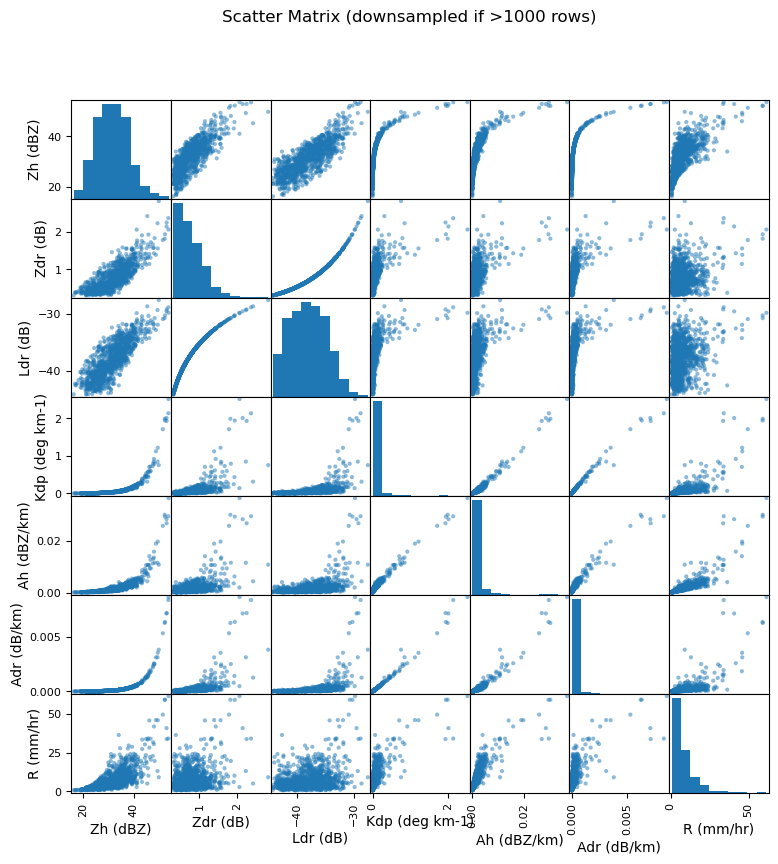

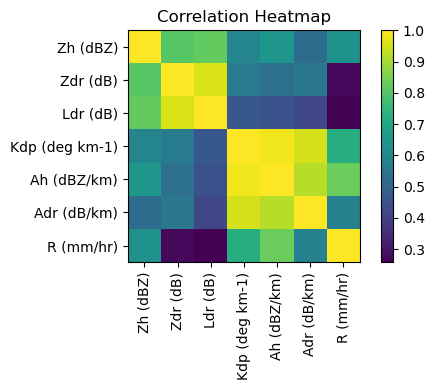

In [3]:
# Quick EDA: scatter matrix (downsample if needed for speed) and correlation heatmap
sample = X.copy()
sample[target_col] = y
if len(sample) > 1000:
    sample = sample.sample(1000, random_state=42)

scatter_matrix(sample, figsize=(9,9), diagonal='hist')
plt.suptitle('Scatter Matrix (downsampled if >1000 rows)')
plt.show()

corr = num_df.corr(numeric_only=True)
fig, ax = plt.subplots()
im = ax.imshow(corr.values, interpolation='nearest')
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
ax.set_title('Correlation Heatmap')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [4]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)

Train size: (14226, 6) Test size: (4743, 6)


In [7]:
# ===== Random Forest Regression: pandas-safe evaluate + per-tree region boxes + interactive UI =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, IntSlider, Dropdown, Checkbox, FloatRangeSlider, interact, Output
from IPython.display import display
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle
import matplotlib as mpl

# ---------- Utilities to ensure pandas usage (avoids "feature names" warning) ----------
def _ensure_df(X, feature_names):
    """Return X as a pandas DataFrame with the given feature_names."""
    if isinstance(X, pd.DataFrame):
        return X
    return pd.DataFrame(X, columns=feature_names)

def _map_max_features(val):
    """
    Robust mapping for RandomForestRegressor across sklearn versions.
    'all' (and legacy 'auto') map to 1.0 meaning 'use all features'.
    """
    if val in (None, 'None'):
        return None
    if val in ('auto', 'all'):
        return 1.0
    # keep 'sqrt' or 'log2' as-is; ints/floats will pass through
    return val

# ---------- Metrics with pandas inputs ----------
def evaluate_model(model, X_tr, y_tr, X_te, y_te, feature_names):
    """Fit/predict with pandas DataFrames to keep feature names consistent."""
    X_tr_df = _ensure_df(X_tr, feature_names)
    X_te_df = _ensure_df(X_te, feature_names)

    model.fit(X_tr_df, y_tr)
    pred = model.predict(X_te_df)

    # RMSE compatibility for older sklearn (no 'squared' kwarg)
    try:
        rmse = mean_squared_error(y_te, pred, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(y_te, pred))
    mae = mean_absolute_error(y_te, pred)
    bias = float(np.mean(pred - y_te))
    return pred, {'RMSE': rmse, 'MAE': mae, 'Bias': bias}

# ---------- Plotting with ensemble band + per-tree region boxes ----------
def plot_results(
    y_true,
    y_pred_mean,
    feat_names,
    model,
    X_te=None,                    # If None, ensemble band & boxes are skipped
    q_low=0.10,
    q_high=0.90,
    show_point_errorbars=False,   # Vertical bars per sample showing ensemble quantiles
    outline_estimators=True,      # Draw thin, shaded boxes per estimator
    max_trees_to_outline=12,      # Cap number of trees for clarity/performance
    nbins=10                      # Number of bins along Observed axis to aggregate boxes
):
    """
    Draws:
      - Predicted (ensemble mean) vs Observed scatter + 1:1 line
      - Ensemble quantile band (q_low..q_high) if X_te is provided
      - Thin, lightly shaded boxes per estimator per Observed bin
        (each box spans min..max tree prediction within that bin)
      - Residual histogram
      - Feature importances
    """
    y_true = np.asarray(y_true)
    y_pred_mean = np.asarray(y_pred_mean)

    have_trees = hasattr(model, "estimators_") and len(getattr(model, "estimators_", [])) > 0
    n_trees = len(getattr(model, "estimators_", [])) if have_trees else 0

    # Per-tree predictions for ensemble band and boxes:
    # Use DataFrame for shape/ordering, but NumPy for individual tree predictions to avoid feature-name warning.
    per_tree_preds = None
    if have_trees and X_te is not None:
        X_te_df = _ensure_df(X_te, feat_names)
        X_te_np = X_te_df.to_numpy()  # trees expect arrays without feature names
        per_tree_preds = np.column_stack([t.predict(X_te_np) for t in model.estimators_])
        q_lo_vec = np.quantile(per_tree_preds, q_low, axis=1)
        q_hi_vec = np.quantile(per_tree_preds, q_high, axis=1)
    else:
        q_lo_vec = y_pred_mean
        q_hi_vec = y_pred_mean

    # --- Predicted vs Observed ---
    fig, ax = plt.subplots()

    if show_point_errorbars and per_tree_preds is not None:
        ax.vlines(y_true, q_lo_vec, q_hi_vec, alpha=0.15, linewidth=0.5)

    ax.scatter(y_true, y_pred_mean, alpha=0.6, s=16, label="Mean prediction")

    # 1:1 line and limits
    ymin = float(np.nanmin([y_true.min(), y_pred_mean.min(), q_lo_vec.min()]))
    ymax = float(np.nanmax([y_true.max(), y_pred_mean.max(), q_hi_vec.max()]))
    ax.plot([ymin, ymax], [ymin, ymax], linewidth=1)
    ax.set_xlim(ymin, ymax)
    ax.set_ylim(ymin, ymax)

    # Ensemble band (quantiles across trees)
    if per_tree_preds is not None:
        sort_idx = np.argsort(y_true)
        ax.fill_between(
            y_true[sort_idx],
            q_lo_vec[sort_idx],
            q_hi_vec[sort_idx],
            alpha=0.15,
            label=f"Ensemble band [{int(q_low*100)}–{int(q_high*100)}]%"
        )

    # Per-estimator boxes per Observed bin
    if outline_estimators and per_tree_preds is not None and n_trees > 0:
        bins = np.linspace(y_true.min(), y_true.max(), nbins + 1)
        bin_idx = np.digitize(y_true, bins) - 1  # 0..nbins-1

        n_show = min(max_trees_to_outline, n_trees)
        cmap = mpl.colormaps.get_cmap("tab20" if n_show <= 20 else "turbo")

        for ti in range(n_show):
            color = cmap(ti % cmap.N)
            preds_t = per_tree_preds[:, ti]

            for b in range(nbins):
                mask = bin_idx == b
                if not np.any(mask):
                    continue
                y_min = np.nanmin(preds_t[mask])
                y_max = np.nanmax(preds_t[mask])
                if not np.isfinite(y_min) or not np.isfinite(y_max) or y_max < y_min:
                    continue

                x0 = bins[b]
                x1 = bins[b + 1]
                rect = Rectangle(
                    (x0, y_min),
                    width=(x1 - x0),
                    height=(y_max - y_min),
                    linewidth=0.8,      # thin outline
                    edgecolor=color,    # distinct color per tree
                    facecolor=color,    # lightly shaded
                    alpha=0.08,
                )
                ax.add_patch(rect)

        ax.legend(loc="best")

    ax.set_xlabel("Observed")
    ax.set_ylabel("Predicted")
    title = "Predicted vs Observed"
    if per_tree_preds is not None:
        title += "\nwith Ensemble Band and Per-Tree Region Boxes"
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

    # --- Residual histogram ---
    fig2, ax2 = plt.subplots()
    resid = y_pred_mean - y_true
    ax2.hist(resid, bins=30)
    ax2.set_title("Residuals (Pred - Obs)")
    ax2.set_xlabel("Residual")
    ax2.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # --- Feature importances ---
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        idx = np.argsort(importances)[::-1]
        fig3, ax3 = plt.subplots()
        ax3.bar(range(len(importances)), importances[idx])
        ax3.set_xticks(range(len(importances)))
        ax3.set_xticklabels([feat_names[i] for i in idx], rotation=90)
        ax3.set_title("Feature Importances")
        ax3.set_ylabel("Importance")
        plt.tight_layout()
        plt.show()

# ---------- Interactive UI (RF hyperparams + visualization controls) ----------
out = Output()

rf_ui = VBox([
    HBox([
        IntSlider(description='n_estimators', value=300, min=50, max=1000, step=50),
        IntSlider(description='max_depth',   value=0,   min=0,  max=50,  step=1),  # 0 -> None
    ]),
    HBox([
        IntSlider(description='min_split',   value=2,   min=2,  max=20,  step=1),
        IntSlider(description='min_leaf',    value=1,   min=1,  max=10,  step=1),
    ]),
    HBox([
        # Removed 'auto'; added 'all' (mapped to 1.0)
        Dropdown(description='max_features', options=['sqrt','log2','None','all'], value='sqrt'),
    ]),
])

viz_ui = VBox([
    HBox([
        IntSlider(description='trees_shown', value=12, min=2,  max=40, step=1),
        IntSlider(description='bins',        value=10, min=5,  max=30, step=1),
    ]),
    HBox([
        FloatRangeSlider(
            description='quantiles',
            value=(0.10, 0.90),
            min=0.0, max=1.0, step=0.05,
            readout_format='.2f',
            layout={'width': '60%'}
        ),
    ]),
    HBox([
        Checkbox(description='show_band', value=True),
        Checkbox(description='per-point error bars', value=False),
        Checkbox(description='outline estimators', value=True),
    ]),
])

#display(VBox([rf_ui, viz_ui]))

def rf_demo_viz(
    n_estimators, max_depth, min_split, min_leaf, max_features,
    trees_shown, bins, quantiles, show_band, per_point_error_bars, outline_estimators
):
    with out:
        out.clear_output()

        mf = _map_max_features(max_features)
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=None if max_depth == 0 else max_depth,
            min_samples_split=min_split,
            min_samples_leaf=min_leaf,
            max_features=mf,
            random_state=42,
            n_jobs=-1
        )

        # Fit and evaluate using DataFrames to keep feature names aligned
        pred, metrics = evaluate_model(rf, X_train, y_train, X_test, y_test, feature_names)
        display(pd.DataFrame([metrics]))

        q_low, q_high = quantiles

        # Use X_test for band/boxes/error bars if any of those are enabled
        X_for_band = X_test if (show_band or outline_estimators or per_point_error_bars) else None

        plot_results(
            y_test.values,
            pred,
            feature_names,
            rf,
            X_for_band,
            q_low=q_low,
            q_high=q_high,
            show_point_errorbars=per_point_error_bars,
            outline_estimators=outline_estimators,
            max_trees_to_outline=trees_shown,
            nbins=bins
        )

# Bind widgets to function
interact(
    rf_demo_viz,
    # RF params
    n_estimators=rf_ui.children[0].children[0],
    max_depth=   rf_ui.children[0].children[1],
    min_split=   rf_ui.children[1].children[0],
    min_leaf=    rf_ui.children[1].children[1],
    max_features=rf_ui.children[2].children[0],
    # Viz params
    trees_shown= viz_ui.children[0].children[0],
    bins=        viz_ui.children[0].children[1],
    quantiles=   viz_ui.children[1].children[0],
    show_band=   viz_ui.children[2].children[0],
    per_point_error_bars=viz_ui.children[2].children[1],
    outline_estimators=   viz_ui.children[2].children[2],
)

display(out)


interactive(children=(IntSlider(value=300, description='n_estimators', max=1000, min=50, step=50), IntSlider(v…

Output()